# Overview

this notebook runs the models and save the time and score
the saved dataframe can be found in `../data/processed/results_{date}`

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
from src.graph import NetworkGraph

In [3]:
import time
import gurobi
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import math

In [4]:
from src.flows import *
from src.models.DQL.DQL import run

In [5]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import *
from flatland.envs.rail_generators import complex_rail_generator,rail_from_manual_specifications_generator,random_rail_generator, RailGenerator
from flatland.envs.schedule_generators import complex_schedule_generator, random_schedule_generator, ScheduleGenerator
from flatland.utils.rendertools import RenderTool
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import *
from flatland.envs.rail_generators import complex_rail_generator,rail_from_manual_specifications_generator,random_rail_generator, RailGenerator,sparse_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator, random_schedule_generator, ScheduleGenerator, sparse_schedule_generator
from flatland.utils.rendertools import RenderTool, AgentRenderVariant

### Helper functions

In [6]:
def create_env(height,width,seed,number_of_agents=5):
    env = RailEnv(width=width,
              height=height,
              rail_generator=complex_rail_generator(nr_start_goal=20, nr_extra=1, 
                                                    min_dist=6, max_dist=99999, seed = seed),
              schedule_generator=complex_schedule_generator(),
              number_of_agents=number_of_agents)
    
    env.reset()
    
    return env

In [7]:
def create_env_sparse(height,width,seed,number_of_agents=5):

    stochastic_data = {'prop_malfunction': 0,  # Percentage of defective agents
                       'malfunction_rate': 30,  # Rate of malfunction occurence
                       'min_duration': 3,  # Minimal duration of malfunction
                       'max_duration': 20  # Max duration of malfunction
                       }
    speed_ration_map = {1.: 1,  # Fast passenger train
                        1. / 2.: 0,  # Fast freight train
                        1. / 3.: 0,  # Slow commuter train
                        1. / 4.: 0}  # Slow freight train
    env = RailEnv(width=height,
                  height=width,
                  rail_generator=sparse_rail_generator(max_num_cities=number_of_agents+2,  
                                                       seed=seed, 
                                                       grid_mode=False,
                                                       max_rails_between_cities=4,
                                                       max_rails_in_city=4,
                                                       ),
                  schedule_generator=sparse_schedule_generator(speed_ration_map,seed = seed),
                  number_of_agents=number_of_agents,
                  stochastic_data=stochastic_data,  
                  obs_builder_object=GlobalObsForRailEnv(),
                  remove_agents_at_target=True
                  )
    env.reset()

    return env

In [8]:
def run_flow_cg(env,*args):
    solver = Solver("cg.log",useDirections=True,verbose=False)
    cost =  solver.solve(env)
    number_of_variables = sum(solver.master.stats["variablesAdded"])
    time_init = solver.stats["timeInit"]
    return cost,number_of_variables, time_init

In [9]:
def run_flow_af(env,*args):
    solver = Solver("comparison_cg.log",method="Arc Formulation",useDirections=True,verbose=False)
    return solver.solve(env)

In [10]:
def run_flow(env,height,width):
    
    #extract the transition matrix
    matrix_rail = np.array(env.rail.grid.tolist())
    
    #build the transition network
    flatlandNetwork = NetworkGraph(matrix_rail)

    #get the sources and sinks of the different agents
    sources = []
    sinks = []
    for agent in env.agents:
        sources.append(agent.initial_position)
        sinks.append(agent.target)
        
    #build the time exanded network and connect the sources and sinks
    TestNetworkTime = TimeNetwork(flatlandNetwork, depth=max(2*(height+width),40))
    TestNetworkTime.connect_sources_and_sink(sources,sinks)
    
    
    #get the Integral Program formulation of the problem and solve it 
    print(sources,sinks)
    mcflow = MCFlow(TestNetworkTime.graph,len(sources),TestNetworkTime.topology)
    mcflow.solve()
    
    #extract the path and compute the scores (total time spent by the agent in the grid)
    cost= 0
    if not mcflow.check_if_feasible():
        return "Infeasible"
    print(mcflow.m.objVal)
    paths = mcflow.extract_paths()
    for agent,path in paths.items():
        print(path)
        cost += -1+len(path)/2
       
    return cost

In [11]:
def run_flow_rl(env,width,height,seed,n_start_goal=20,initial_value = 0,
             learning_rate = 0.8,gamma = 0.9,epsilon = 0.1,threshold = 0.3):
    number_agents = len(env.agents)
    n_episodes = width*height*number_agents*15
    n_steps = 2*(width+height)
    print(seed)
    cost, n_episodes, total_time = run(number_agents,
                                    width,height,
                                    n_start_goal,
                                    seed,
                                    n_episodes,
                                    n_steps,
                                    initial_value,
                                    learning_rate,
                                    gamma,
                                    epsilon,
                                    threshold)
    
    return cost, n_episodes, total_time

In [12]:
def run_experiment_and_save_results(method, results,agents = 4, repetition = 5, 
                                    pathToSavedGrids = None, grids_size = None):
    nodes = []
    edges = []
    sizes_list = []
    if pathToSavedGrids is None:
        for sizes in tqdm(grids_size):
            for i in range(repetition):
                seed = sizes[0]*sizes[1]+i
                print(f'seed {seed}')
                env = create_env_sparse(sizes[0],sizes[1],seed,number_of_agents=agents)
                print("env created")
                
                start = time.time()
                cost,number_of_variables, time_init = run_flow_cg(env,sizes[0],sizes[1])
                sizes_list.append(sizes[0]*sizes[1])                    
                time_spent = time.time()-start
                results = results.append({'Size of the grid' : sizes[0]*sizes[1] , 
                                          'Score' : cost, "Time":time_spent,"Variables added":number_of_variables, 
                                          "time initial solution": time_init,
                                          "Type":"Column Generation"} , 
                                         ignore_index=True)
                results.to_csv("../data/processed/results_comparison"+str(agents)+".csv")
                results.to_csv("../data/processed/results_comparison"+str(agents)+".csv")
                start = time.time()
                cost = run_flow_af(env,sizes[1],sizes[0],seed)
                sizes_list.append(sizes[0]*sizes[1])                    
                time_spent = time.time()-start
                results = results.append({'Size of the grid' : sizes[0]*sizes[1] , 
                                          'Score' : cost, "Time":time_spent, "Variables added": None,
                                           "time initial solution": None,
                                          "Type":"Arc Formulation"} , 
                                         ignore_index=True)
                results.to_csv("../data/processed/results_comparison"+str(agents)+".csv")
                print("---")
                                
    else:
        raise NotImplementedError("Load the map and proceed to inference")

### Constant definition

In [17]:
grids_size = [(30,30),(40,40),(50,50),(100,100)]

In [14]:
results = pd.DataFrame()

## Actual run

In [ ]:
for number in [10,20,30,40,50]:
    results = pd.DataFrame()
    try:
        run_experiment_and_save_results(run_flow, results, agents = number, repetition=2, grids_size=grids_size)
    except:
        pass

  0%|          | 0/4 [00:00<?, ?it/s]

seed 900
env created
Had to drop 5 agents, conflict with their starting position
[2, 4, 5, 6, 9]
 configuration is to clean problematic agent, deleting agent from env



0it [00:00, ?it/s]
1it [00:01,  1.11s/it]
2it [00:01,  1.04it/s]
3it [00:03,  1.07s/it]
4it [00:03,  1.04it/s]
5it [00:04,  1.09it/s]

Academic license - for non-commercial use only


Had to drop 5 agents, conflict with their starting position
[2, 4, 5, 6, 9]
 configuration is to clean problematic agent, deleting agent from env
Setting up the arc formulation may take some time and RAM



  0%|          | 0/4 [00:00<?, ?it/s]

seed 900
env created
Had to drop 14 agents, conflict with their starting position
[2, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19]
 configuration is to clean problematic agent, deleting agent from env




0it [00:00, ?it/s]

1it [00:01,  1.55s/it]

2it [00:02,  1.32s/it]

3it [00:03,  1.14s/it]

4it [00:03,  1.06s/it]

5it [00:04,  1.00s/it]

6it [00:05,  1.04it/s]


Had to drop 14 agents, conflict with their starting position
[2, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19]
 configuration is to clean problematic agent, deleting agent from env
Setting up the arc formulation may take some time and RAM


# PLOTS

In [6]:
df = pd.read_csv("../data/processed/results_comparison5.csv", index_col = 'Unnamed: 0')

In [7]:
df

,Score,Size of the grid,Time,Type,Variables added
0,218.0,500.0,11.598443,Column Generation,5.0
1,218.0,500.0,184.310935,Arc Formulation,NaN
2,133.0,500.0,12.028289,Column Generation,0.0
3,133.0,500.0,192.104977,Arc Formulation,NaN
4,279.0,500.0,10.280787,Column Generation,0.0
5,279.0,500.0,232.823883,Arc Formulation,NaN
6,211.0,500.0,5.827799,Column Generation,1.0
7,211.0,500.0,86.751172,Arc Formulation,NaN
8,340.0,625.0,21.810992,Column Generation,10.0
9,336.0,625.0,340.561623,Arc Formulation,NaN


In [36]:
rl_values = df[df.Type == "RL"].Score.values
sizes = df[df.Type == "RL"]["Size of the grid"].values
co_values = df[df.Type == "CO"].Score.values
diff = rl_values-co_values
diff = [math.ceil(x) for x in diff]


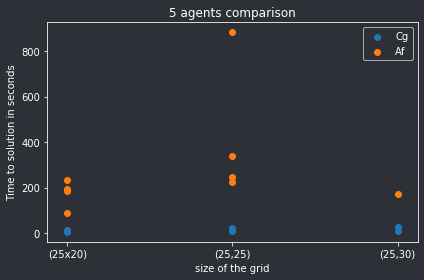

In [16]:
plt.rcParams['savefig.facecolor'] = (46/255., 48/255., 55/255.)
plt.rcParams['axes.facecolor'] = (46/255., 48/255., 55/255.)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.spines['bottom'].set_color("white")
ax.spines['top'].set_color("white") 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
fig.set_facecolor((46/255., 48/255., 55/255.))
ax.set_facecolor((46/255., 48/255., 55/255.))


plt.scatter(df[df.Type == 'Column Generation']['Size of the grid'].values,
            df[df.Type == 'Column Generation'].Time,label = "Cg")
plt.scatter(df[df.Type == 'Arc Formulation']['Size of the grid'].values,
            df[df.Type == 'Arc Formulation'].Time, label = "Af")
#sizes_jitter = [np.random.normal(x, 2,1) for x in sizes]
#plt.scatter(sizes_jitter,diff)
plt.xlabel("size of the grid")

x1 = [25*20,25*25,25*30]
squad = ['(25x20)','(25,25)','(25,30)']#,'(20,20)','(25,20)','(25,25)','(25,30)']

ax.set_xticks(x1)
ax.set_xticklabels(squad)

plt.ylabel("Time to solution in seconds")
plt.title("5 agents comparison")

l = plt.legend()
for text in l.get_texts():
    text.set_color("white")



ax = plt.gca()
plt.tight_layout()
plt.savefig("../data/processed/comparison_score.png", dpi = 300)

In [ ]:
df_20_agents = pd.read_csv("../data/processed/results_20_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
df_10_agents = pd.read_csv("../data/processed/results_10_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
df_4_agents = pd.read_csv("../data/processed/results_4_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
plt.rcParams['savefig.facecolor'] = (46/255., 48/255., 55/255.)
plt.rcParams['axes.facecolor'] = (46/255., 48/255., 55/255.)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.spines['bottom'].set_color("white")
ax.spines['top'].set_color("white") 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
fig.set_facecolor((46/255., 48/255., 55/255.))
ax.set_facecolor((46/255., 48/255., 55/255.))


plt.scatter(df_4_agents['Size of the grid'],df_4_agents['Time'].values/60, label = "4 trains",alpha= 0.8)
plt.scatter(df_10_agents['Size of the grid'],df_10_agents['Time'].values/60, label = "10 trains",alpha = 0.8)
plt.scatter(df_20_agents['Size of the grid'],df_20_agents['Time'].values/60, label = "20 trains",alpha = 0.8)


plt.xlabel("size of the grid (number of cells)")

x1 = [20**2,40**2,50*50,60*60]
squad = ['(20x20)','(40x40)','(50,50)','(60x60)']

ax.set_xticks(x1)
ax.set_xticklabels(squad)

plt.ylabel("time until solution (min)")
#plt.title("Experiment of multicommodity flow formulation until memory error (model > 40 Gb)")

l = plt.legend()
for text in l.get_texts():
    text.set_color("white")



ax = plt.gca()
plt.tight_layout()
plt.savefig("../data/processed/time.png", dpi = 300)